# Fakenews detection
Karolina Mączka, Tymoteusz Urban

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from wordcloud import WordCloud
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tymek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tymek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tymek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tymek\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df=pd.read_csv('PreProcessedData.csv', header=0, sep=',', index_col=False)

In [3]:
df.head()

,Unnamed: 0,title,text,Ground Label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


In [4]:
# Remove index column and rename Gound Label for easier use
df = df[['title', 'text', 'Ground Label']]
df.rename(columns={'Ground Label': 'label'}, inplace=True)
df.head()

,title,text,label
0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


## Train test split

In [5]:
# Splitting data into training and testing sets
X_rest, X_test, y_rest, y_test = train_test_split(df[['title', 'text']], df['label'], test_size=0.30, random_state=42)

In [6]:
y_rest.value_counts()

fake    29459
true    18872
Name: label, dtype: int64

In [7]:
X_train, X_validate, y_train, y_validate = train_test_split(X_rest, y_rest, test_size=0.30, random_state=42)

In [8]:
print(y_train.value_counts())
print(y_validate.value_counts())

fake    20645
true    13186
Name: label, dtype: int64
fake    8814
true    5686
Name: label, dtype: int64


The ratio of false and true is the same everywhere, so we can assume that this is a good separation of data

In [9]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train_df.to_csv('training_data.csv', index=False)

In [10]:
testing_df = pd.concat([X_test, y_test], axis=1)
testing_df.to_csv('testing_data.csv', index=False)

In [11]:
validate_df = pd.concat([X_validate, y_validate], axis=1)
validate_df.to_csv('fakenws_validation.csv', index=False)

In [9]:
df2 = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

## Getting to know the data

In [10]:
df2.head()

,title,text,label
0,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
1,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,fake
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,Nathan Domingo is the founder of Identity Eur...,fake
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,"When it comes to limiting our free speech, not...",fake
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,Little Miss Sunshine has fooled a lot of peo...,fake


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33831 entries, 0 to 33830
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   33497 non-null  object
 1   text    33800 non-null  object
 2   label   33831 non-null  object
dtypes: object(3)
memory usage: 793.0+ KB




## Data Preprocessing

### Encoding

In [12]:
# Converting fake and true into numeric values
df2.loc[df2["label"] == "fake","label"] = 0
df2.loc[df2["label"] == "true","label"] = 1

In [13]:
# Before pipeline function
def encodeLabels(df):
    df.loc[df["label"] == "fake","label"] = 0
    df.loc[df["label"] == "true","label"] = 1
    return df

### NaNs

In [14]:
# In order to perform operations on data we have to convert Nans into empty strings
df2.fillna('', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33831 entries, 0 to 33830
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   33831 non-null  object
 1   text    33831 non-null  object
 2   label   33831 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 793.0+ KB


In [15]:
# transformer function
def handleNa(df):
    df.fillna('', inplace=True)
    print('NaNs replaced')
    return df

### Combine columns

Because of the fact that we will be analysing only words (or sequences of them) we are combining title and text columns - there will be no difference for our model which column those words come from

In [16]:
df2.loc[2]

title    THE GUY WHO Punched “Moldylocks” Speaks Out Ab...
text     Nathan Domingo is the founder of  Identity Eur...
label                                                    0
Name: 2, dtype: object

In [17]:
df2['text'] = df2[['title', 'text']].apply(" ".join, axis=1)

In [18]:
df2.loc[2]['text']

'THE GUY WHO Punched “Moldylocks” Speaks Out About Violent Antifa Female With A Bottle [VIDEO] Nathan Domingo is the founder of  Identity Europa  and is the guy who was seen by millions of viewers punching a female Antifa thug the media tried to portray as a helpless woman that just happened to be in the area when fighting broke out at a free speech rally in Berkeley, CA on April 16th.The last time these two group clashed, the Trump supporters were seriously outnumbered. This time was a different story. Trump supporters came prepared for the unprovoked attacks of these hate groups and took them to task. With all the violence that happened yesterday, leftist media outlets seemed to be obsessed with reporting on the video that was taken of an alleged Trump supporter who punched an antifa female who was part of the violent group  Oak Roots Collective  that traveled to Berkeley to confront Trump supporters and shut down their right to free speech.Here s the video. At the 18 second mark you

In [19]:
df2 = df2.drop(columns='title')

In [20]:
df2.head()

,text,label
0,In the Western World Respect for Law No Longer...,0
1,"WATCH: President Obama Unleashes On Trump, Sa...",0
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,0
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,0
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,0


In [21]:
# transformer function
def combineColumns(df):
    df['text'] = df[['title', 'text']].apply(" ".join, axis=1)
    df = df.drop(columns='title')
    print('Columns combined')
    return df

### Outliers

(array([3.3423e+04, 3.3800e+02, 4.4000e+01, 1.4000e+01, 2.0000e+00,
        1.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([5.000000e+00, 1.434840e+04, 2.869180e+04, 4.303520e+04,
        5.737860e+04, 7.172200e+04, 8.606540e+04, 1.004088e+05,
        1.147522e+05, 1.290956e+05, 1.434390e+05]),
 <BarContainer object of 10 artists>)

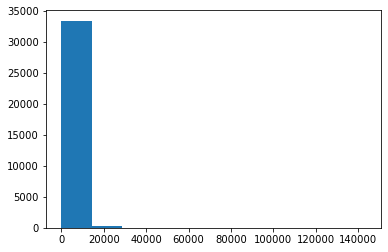

In [22]:
df2['textlength'] = df2['text'].apply(len)
plt.hist(df2['textlength'])

In [23]:
print(df2[(df2['textlength'] > 40000)].count())
df2[(df2['textlength'] > 40000)].head()

text          32
label         32
textlength    32
dtype: int64


,text,label,textlength
720,Re: Why Are So Many People Choosing To Leave T...,0,115924
1612,Re: Why Is Obama Threatening Russia With World...,0,97429
4245,Benny Morris’s Untenable Denial of the Ethnic ...,0,92823
4709,President-Elect Donald Trump's First Televised...,0,41697
4762,Re: The Velocity Of Money In The U.S. Falls To...,0,43623


In [24]:
def shortenLongText(text):
    return text[:40000]

In [25]:
# Shortening really long texts (above 40000 words) - no influence on predictibilty, but will speed up the transformations
df2['text'] = df2['text'].apply(shortenLongText)
df2 = df2.drop(columns='textlength')
df2

,text,label
0,In the Western World Respect for Law No Longer...,0
1,"WATCH: President Obama Unleashes On Trump, Sa...",0
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,0
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,0
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,0
...,...,...
33826,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,0
33827,Russia denies its planes killed civilians in S...,1
33828,Hungary’s “Wall” Versus the U.S. “Wall” Op-Ed ...,0
33829,Pastor Caught Trump’s Spiritual Advisor Steal...,0


In [26]:
# Transformer function
def shortenOutliers(df):
    df['text'] = df['text'].apply(shortenLongText)
    print('Outliers removed')
    return df

### Cleaning texts

In [27]:
def deleteUrl(text):
    return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

In [28]:
# Punctuation and number removal
def remove_punctuations(s):
    s = re.sub(r'[^a-zA-Z\s]', '', s)
    return s

In [29]:
# Deleting URLs
df2['text'] = df2['text'].apply(deleteUrl)
df2['text'] = df2['text'].apply(remove_punctuations)

In [30]:
df22 = df2.copy()
df22['text'] = df22['text'].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [31]:
# Transformer function
def cleanText(df):
    df['text'] = df['text'].apply(deleteUrl)
    df['text'] = df['text'].apply(remove_punctuations)
    df['text'] = df['text'].apply(lambda x: x.strip() if isinstance(x, str) else x)
    print('Punctuation removed')
    return df

### Extracting english

In [32]:
# Shorter column for language detection
def shortenText(text):
    return text[:500]

In [33]:
df3 = df22.copy()
df3['shorttext'] = df3['text'].apply(shortenText)

In [34]:
df3[df3['shorttext'].apply(len) < 20]

,text,label,shorttext
851,Internet Flasher,0,Internet Flasher
1060,He lied PERIOD,0,He lied PERIOD
1338,great article,0,great article
1623,,0,
2392,HE KNEW,0,HE KNEW
...,...,...,...
32921,,0,
33469,Florida for Trump,0,Florida for Trump
33496,PravdaRu,0,PravdaRu
33517,,0,


In [35]:
# Deleting very short texts
df3 = df3[df3['shorttext'].apply(len) > 20]

In [36]:
df3.head()

,text,label,shorttext
0,In the Western World Respect for Law No Longer...,0,In the Western World Respect for Law No Longer...
1,WATCH President Obama Unleashes On Trump Says ...,0,WATCH President Obama Unleashes On Trump Says ...
2,THE GUY WHO Punched Moldylocks Speaks Out Abou...,0,THE GUY WHO Punched Moldylocks Speaks Out Abou...
3,SAY WHAT AMAZON TELLS CUSTOMER THEY WERE FORCE...,0,SAY WHAT AMAZON TELLS CUSTOMER THEY WERE FORCE...
4,ANTIGUN Zealot KATIE COURIC Hit With MILLION ...,0,ANTIGUN Zealot KATIE COURIC Hit With MILLION ...


In [37]:
DetectorFactory.seed = 0
df3['lang'] = df3['shorttext'].apply(detect)

In [38]:
df3[df3['lang'] != 'en']['label'].value_counts()

0    254
Name: label, dtype: int64

All texts in languages other than english are fake. We delete them, because otherwise any text in another language would be classified as fake news

In [39]:
# We will be working only with english texts
df3 = df3[df3['lang']=='en']

In [40]:
df3 = df3[['text', 'label']].reset_index(drop=True)
df3

,text,label
0,In the Western World Respect for Law No Longer...,0
1,WATCH President Obama Unleashes On Trump Says ...,0
2,THE GUY WHO Punched Moldylocks Speaks Out Abou...,0
3,SAY WHAT AMAZON TELLS CUSTOMER THEY WERE FORCE...,0
4,ANTIGUN Zealot KATIE COURIC Hit With MILLION ...,0
...,...,...
33497,STATES ATTORNEY LIED BALTIMORE POLICE HAD PROB...,0
33498,Russia denies its planes killed civilians in S...,1
33499,Hungarys Wall Versus the US Wall OpEd by Cathe...,0
33500,Pastor Caught Trumps Spiritual Advisor Stealin...,0


In [41]:
#transformer function
def dropLanguages(df):
    DetectorFactory.seed = 0
    df['shorttext'] = df['text'].apply(shortenText)
    df = df[df['shorttext'].apply(len) > 20]
    print('Text cleaned')
    df['lang'] = df['shorttext'].apply(detect)
    df = df[df['lang']=='en']
    df = df.drop(columns=['shorttext', 'lang'])
    print('Languages dropped')
    return df

### Removing stopwords

In [42]:
# Stopwords removal
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def remove_stopwords(s):
    s = [lemmatizer.lemmatize(word.lower()) for word in s if not word.lower() in stop]
    return s

In [43]:
df4 = df3.copy()
df4['text'] = df4['text'].apply(word_tokenize)
df4['text'] = df4['text'].apply(remove_stopwords)

In [44]:
def list2string(text):
    text = " ".join(wrd for wrd in text)
    return text

In [45]:
df4["text"] = df4["text"].apply(list2string)
df4.head()

,text,label
0,western world respect law longer exists wester...,0
1,watch president obama unleashes trump say terr...,0
2,guy punched moldylocks speaks violent antifa f...,0
3,say amazon tell customer forced federal govern...,0
4,antigun zealot katie couric hit million defama...,0


In [46]:
# Transformer function
def removeStopwords(df):
    df['text'] = df['text'].apply(word_tokenize)
    print('Words tokenized')
    df['text'] = df['text'].apply(remove_stopwords)
    print('Stopwords removed')
    df['text'] = df['text'].apply(list2string)
    return df

In [57]:
# żeby zapisać dane
df4.to_csv('train_data.csv', index=False)

### Word Cloud

In [53]:
df_fake = df4[df4["label"] == 0]
df_true = df4[df4["label"] == 1]

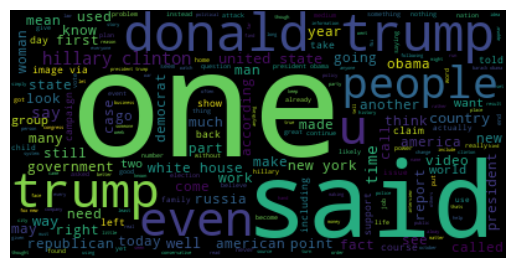

In [54]:
# Fake
consolidated_f = ' '.join(
    word for word in df_fake['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_f)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

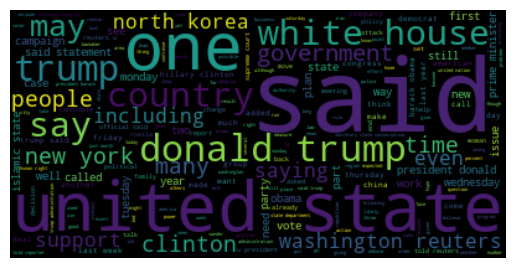

In [55]:
# True
consolidated_t = ' '.join(
    word for word in df_true['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_t)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
# Bag of words - liczba wystąpień każdego słowa w danym tekście
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df4['text'])

In [48]:
# Zamiana częstości w częstotliwość wystąpień
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [49]:
X_train_tfidf.shape

(33502, 186097)

## Pipeline

In [50]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

na_transformer = FunctionTransformer(handleNa)
column_transformer = FunctionTransformer(combineColumns)
outliers_transformer = FunctionTransformer(shortenOutliers)
punctuation_transformer = FunctionTransformer(cleanText)
language_transformer = FunctionTransformer(dropLanguages)
stopwords_transformer = FunctionTransformer(removeStopwords)

custom_pipe = Pipeline([
    ("na", na_transformer),
    ('columns', column_transformer),
    ('outliers', outliers_transformer),
    ('punctuations', punctuation_transformer),
    ("language", language_transformer),
    ("stopwords", stopwords_transformer),
])

In [51]:
train = pd.read_csv('training_data.csv', index_col=False)

In [52]:
train

,title,text,label
0,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
1,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,fake
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,Nathan Domingo is the founder of Identity Eur...,fake
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,"When it comes to limiting our free speech, not...",fake
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,Little Miss Sunshine has fooled a lot of peo...,fake
...,...,...,...
33826,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,Marilyn Mosby held a press conference today in...,fake
33827,Russia denies its planes killed civilians in S...,MOSCOW (Reuters) - Russia s Defence Ministry d...,true
33828,Hungary’s “Wall” Versus the U.S. “Wall”,Op-Ed by Catherine J. Frompovich\r\nCurrently ...,fake
33829,Pastor Caught Trump’s Spiritual Advisor Steal...,It seems that Donald Trump s spiritual advisor...,fake


In [53]:
train = encodeLabels(train)

In [54]:
train_transformed = custom_pipe.transform(train)

NaNs replaced
Columns combined
Outliers removed
Punctuation removed
Text cleaned


<ipython-input-41-bd5cd7bf9918>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lang'] = df['shorttext'].apply(detect)


Languages dropped
Words tokenized
Stopwords removed


In [55]:
train_transformed

,text,label
0,western world respect law longer exists wester...,0
1,watch president obama unleashes trump say terr...,0
2,guy punched moldylocks speaks violent antifa f...,0
3,say amazon tell customer forced federal govern...,0
4,antigun zealot katie couric hit million defama...,0
...,...,...
33826,state attorney lied baltimore police probable ...,0
33827,russia denies plane killed civilian syria deir...,1
33828,hungary wall versus u wall oped catherine j fr...,0
33829,pastor caught trump spiritual advisor stealing...,0


In [56]:
train_transformed_x = train_transformed['text']
train_transformed_y = train_transformed['label']

### Transforming testing dataset

In [57]:
test = pd.read_csv('testing_data.csv', index_col=False)

In [58]:
test = encodeLabels(test)

In [59]:
test_transformed = custom_pipe.transform(test)

NaNs replaced
Columns combined
Outliers removed
Punctuation removed
Text cleaned


<ipython-input-41-bd5cd7bf9918>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lang'] = df['shorttext'].apply(detect)


Languages dropped
Words tokenized
Stopwords removed


In [60]:
test_transformed_x = test_transformed['text']
test_transformed_y = test_transformed['label']

## Model

### Baseline model

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [62]:
# Pipeline with ready-made transformers and model
model_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [63]:
model_pipe.fit(train_transformed_x, train_transformed_y)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [64]:
predicted = model_pipe.predict(test_transformed_x)

In [65]:
predicted_probability = model_pipe.predict_proba(test_transformed_x)

In [66]:
np.mean(predicted == test_transformed_y)

0.8680691136274893

### Logistic regression

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

lr_pipe = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(random_state=42))
])

In [68]:
lr_pipe.fit(train_transformed_x, train_transformed_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=5000)),
                ('classifier', LogisticRegression(random_state=42))])

In [69]:
lr_predicted = lr_pipe.predict(test_transformed_x)
lr_predicted_probability = lr_pipe.predict_proba(test_transformed_x)

In [ ]:
lr_pipe2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()), 
    ('classifier', LogisticRegression(random_state=42))
])
lr_pipe2.fit(train_transformed_x, train_transformed_y)
lr_predicted2 = lr_pipe2.predict(test_transformed_x)
lr_predicted_probability2 = lr_pipe2.predict_proba(test_transformed_x)

### SVM

In [70]:
svm_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

In [71]:
svm_pipe.fit(train_transformed_x, train_transformed_y)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [72]:
svm_predicted = svm_pipe.predict(test_transformed_x)

In [73]:
np.mean(svm_predicted == test_transformed_y)

0.9255173760249903

A lot better than Naive-Bayes classifier. Lets check the score if we also take bigrams into account

In [74]:
svm_pipe_2 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

In [75]:
svm_pipe_2.fit(train_transformed_x, train_transformed_y)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [76]:
svm2_predicted = svm_pipe_2.predict(test_transformed_x)

In [77]:
np.mean(svm2_predicted == test_transformed_y)

0.9095080046856696

It's actually worse, so we will be taking only single words into account. Let's play with the classifier parameters

In [78]:
huber_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),  
    ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=10, tol=None)),
])

In [79]:
huber_pipe.fit(train_transformed_x, train_transformed_y)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, loss='modified_huber', max_iter=10,
                               random_state=42, tol=None))])

In [80]:
huber_predicted = huber_pipe.predict(test_transformed_x)

In [81]:
huber_predicted_prob = huber_pipe.predict_proba(test_transformed_x)

In [82]:
np.mean(huber_predicted == test_transformed_y)

0.9413803201874268

dictionary of models and probabilities of false and true labels

In [105]:
model_dict = {'Logistic regression': [lr_predicted, lr_predicted_probability]}
model_dict['Logistic regression with tfidf'] = [lr_predicted2, lr_predicted_probability2]
model_dict['Multinomial Naive Bayes'] = [predicted, predicted_probability]
model_dict['SVM'] = [svm_predicted, np.empty(shape=(0,))]
model_dict['SVM with bigrams'] = [svm2_predicted, np.empty(shape=(0,))]
model_dict['SVM modified huber'] = [huber_predicted, huber_predicted_prob]

# Accuracy

In [ ]:
# precision the ability of the classifier not to label as positive a sample that is negative.
# tp / (tp + fp)
# The recall is intuitively the ability of the classifier to find all the positive samples. 
# tp / (tp + fn)
# F1 = 2 * (precision * recall) / (precision + recall)
# log_loss - how far is the predicted value from actual

In [84]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss, brier_score_loss
def accuracy(name, y_true,y_pred, y_probabilities = np.empty(shape=(0,))):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, pos_label=0)
    F1_score = f1_score(y_true, y_pred, pos_label=0)
    auc_score = roc_auc_score(y_true, y_pred)
    if len(y_probabilities.tolist()) == 0:
        Log_loss=None
    else:
        Log_loss = log_loss(y_true, y_probabilities)
    my_dict = {'Classifier': name, 'precision': [precision], 'recall': [recall], 'f1 score': [F1_score], 'auc score': [auc_score], 'log loss': [Log_loss] }
    df = pd.DataFrame.from_dict(my_dict) 
    return df

In [85]:
def accuracy_dataframe(model_dict):
    accuracy_df = pd.DataFrame()
    for name, val in model_dict.items():
        accuracy_df = accuracy_df.append(pd.DataFrame(accuracy(name ,test_transformed_y, val[0], val[1])).set_index('Classifier'))
    accuracy_df.round(decimals=3)
    return accuracy_df

In [106]:
accuracy_dataframe(model_dict)

,precision,recall,f1 score,auc score,log loss
Classifier,,,,,
Logistic regression,0.944614,0.965127,0.958977,0.945441,0.273633
Logistic regression with tfidf,0.956505,0.973144,0.961124,0.946205,0.162712
Multinomial Naive Bayes,0.924676,0.962241,0.898798,0.841864,0.342787
SVM,0.945115,0.967933,0.940562,0.913715,NaN
SVM with bigrams,0.951745,0.973625,0.929085,0.891667,NaN
SVM modified huber,0.951013,0.970338,0.952733,0.933322,0.238783


In [107]:
from sklearn.metrics import roc_auc_score
for name, val in model_dict.items():
    print(f"{name}: auc = {round(roc_auc_score(test_transformed_y, val[0]),3)}")

Logistic regression: auc = 0.945
Logistic regression with tfidf: auc = 0.946
Multinomial Naive Bayes: auc = 0.842
SVM: auc = 0.914
SVM with bigrams: auc = 0.892
SVM modified huber: auc = 0.933


In [91]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

def plot_histogram_pred(model_dict):
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, figure=fig)
    grid_positions = [(0, 0), (0,1), (1, 0)]
    i=0
    for name, val in model_dict.items():
        if len(val[1].tolist()) == 0:
            continue
        else:
            row, col = grid_positions[i]
            ax = fig.add_subplot(gs[row, col])
            i+=1
            data = val[1][:, 0]
            sns.histplot(data, ax=ax, bins=10, kde=False, color="teal")
            sns.set_context("notebook", font_scale=1.2)
            plt.title(name, fontsize=16)
            plt.xlabel('Predicted value', fontsize=14)
            plt.ylabel('Count', fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.ylim(0, 12000)
    plt.tight_layout()
    plt.show()

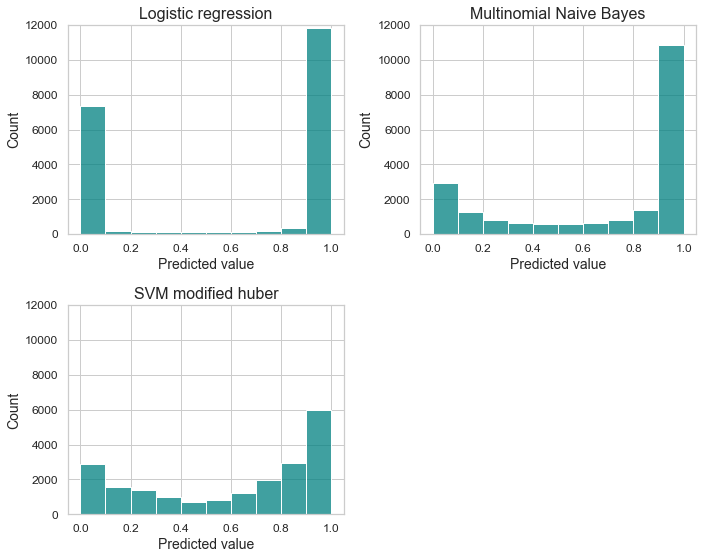

In [92]:
plot_histogram_pred(model_dict)